Shape of scaled_data: (20, 5)
X_train shape before reshaping: (12, 2, 5)
X_val shape before reshaping: (1, 2, 5)
X_test shape before reshaping: (1, 2, 5)
X_train shape after reshaping: (12, 2, 5)
X_val shape after reshaping: (1, 2, 5)
X_test shape after reshaping: (1, 2, 5)
Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step - loss: 0.1761 - val_loss: 0.8548
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1669 - val_loss: 0.8205
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1580 - val_loss: 0.7868
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1493 - val_loss: 0.7536
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1408 - val_loss: 0.7207
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1325 - val_loss: 0.6880
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1244 - val_loss: 0.6554
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1164 - val_loss: 0.6228
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1085 - val_loss: 0.5901
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1007 - val_loss: 0.5571
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0930 - val_loss: 0.5239
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0853 - val_loss: 0.4904
Epoch 13/50

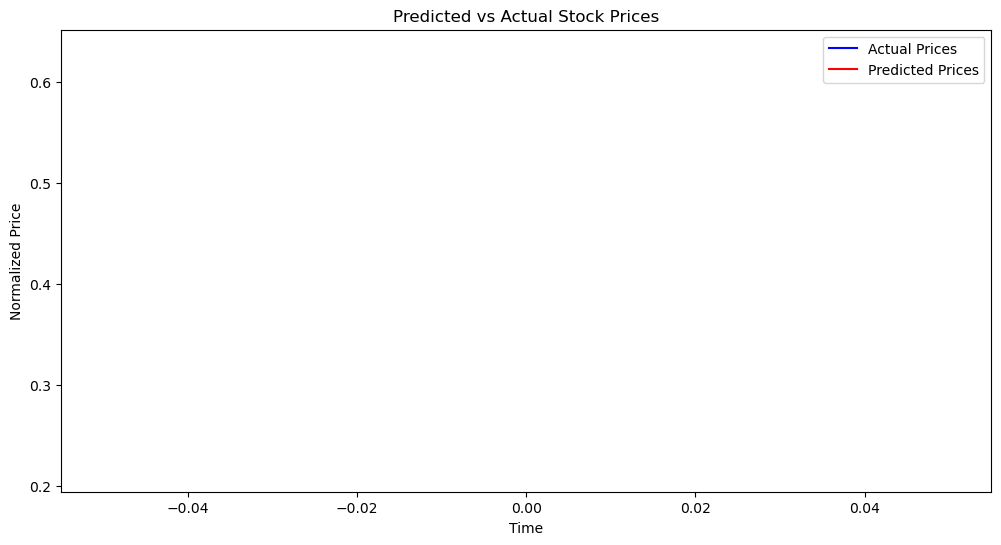

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# loadig the dataset 
data = pd.read_csv('Google_Stock_Price_Test.csv')  

# removing commas and converting columns to numeric
data['Volume'] = data['Volume'].replace({',': ''}, regex=True) 
data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')  

# converting other columns to numeric 
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['High'] = pd.to_numeric(data['High'], errors='coerce')
data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')


data = data.ffill()

# normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# checkig the shape of scaled_data to ensure it's not empty
print(f"Shape of scaled_data: {scaled_data.shape}")

#creating sequences for RNN input
def create_sequences(data, sequence_length):
    X, y = [], []
    
    if len(data) < sequence_length:
        print(f"Error: dataset too small to create sequences of length {sequence_length}")
        return np.array(X), np.array(y)
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  
        y.append(data[i, 3])  
    return np.array(X), np.array(y)

# defining sequence length and spliting the data
sequence_length = 2  


train_size = int(len(scaled_data) * 0.7)  
validation_size = int(len(scaled_data) * 0.15)  
test_size = len(scaled_data) - train_size - validation_size  

train_data = scaled_data[:train_size]
validation_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:]

# generating training, validation, and test sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(validation_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# checking the shapes of X_train, X_val, and X_test before reshaping
print(f"X_train shape before reshaping: {X_train.shape}")
print(f"X_val shape before reshaping: {X_val.shape}")
print(f"X_test shape before reshaping: {X_test.shape}")


if X_train.shape[0] > 0 and X_val.shape[0] > 0 and X_test.shape[0] > 0:
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))  
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  

    # checking the shapes 
    print(f"X_train shape after reshaping: {X_train.shape}")
    print(f"X_val shape after reshaping: {X_val.shape}")
    print(f"X_test shape after reshaping: {X_test.shape}")
else:
    print("Error: Unable to generate sequences due to insufficient data length.")

# Building a Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(50),
    Dense(1)  
])


model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

#predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()
